In [1]:
import qutip
import jax
import jax.numpy as jnp
import optax
import numpy as np 

from qurveros import losses, barqtools, plottools, frametools
from qurveros.optspacecurve import BarqCurve
from qurveros.qubit_bench import simulator, noise_experiments, quantumtools
import qurveros.plot_configs
from qurveros.spacecurve import SpaceCurve

import matplotlib
matplotlib.rcParams['figure.dpi'] = 150

import matplotlib.pyplot as plt



Defiene the square pulse for the cavities

The curve will be constructed using the tangent vector.


Array(1., dtype=float64)

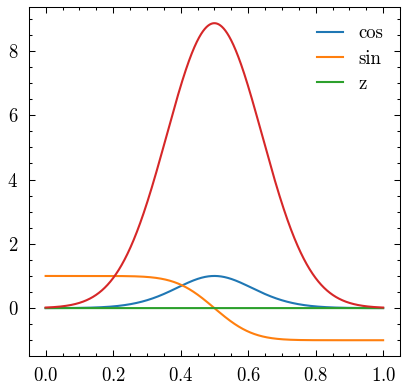

In [2]:
def gaussian(x, s):

    df = jax.scipy.special.erf( ( x - 0.5) /s) * 2 / (s * jnp.sqrt( jnp.pi ))
    return df


def make_gaussian_deriv(n):

    deriv = gaussian

    for _ in range(n):
        deriv = jax.grad(deriv, argnums=0)
    
    return deriv

gaussian_deriv_n = make_gaussian_deriv(0)


n = 0

deriv = make_gaussian_deriv(n)

x = jnp.linspace(0,1, 4096)

s  = 0.20
b1 = deriv(0., s) - deriv(1., s)

b  = (2*0 + 1) * jnp.pi/ b1


def g_tangent(x, params):

    s, b = params  

    return [jnp.cos( b * gaussian_deriv_n(x, s)) , jnp.sin( b* gaussian_deriv_n(x, s)) , jnp.zeros_like(x)]


spacecurve = SpaceCurve(curve = g_tangent,
                        order = 1,
                        interval = [0, 1],
                        params = [s, b])



spacecurve.evaluate_frenet_dict()
spacecurve.evaluate_control_dict('XY')

tangent_X1 = spacecurve.frenet_dict['frame'][:,0,:]
omega_X1   = spacecurve.control_dict['omega']
time       = jnp.linspace(0,1, 4096) 


fig = plt.figure(figsize=(3, 3))
plt.plot(time, tangent_X1[:,0], label = 'cos')
plt.plot(time, tangent_X1[:,1], label = 'sin')
plt.plot(time, tangent_X1[:,2], label = 'z')


plt.plot(time,omega_X1)
plt.legend()


jnp.trapezoid(omega_X1, time)/jnp.pi

In [3]:
# fig.savefig("Gaussian_pulse.svg")

In [4]:
deriv = make_gaussian_deriv(4)

In [5]:
import scipy

print(np.max(omega_X1), np.pi * 5/ ( scipy.special.erf(5/2) * np.sqrt(np.pi)) )

8.865873936747974 8.865877241157289


In [6]:
deriv(0.5,1)

Array(0., dtype=float64, weak_type=True)

In [7]:
type(tangent_X1)

jaxlib.xla_extension.ArrayImpl

In [8]:

def jax_int(f, x_values):
    
    dx = jnp.diff(x_values)
    ret = f[..., 1:] + f[..., :-1]
    ret *= dx
    return jnp.insert(ret.cumsum(axis=-1)/2,0,0)


def make_zz_loss(f_linear_list):

    t_linear = jnp.linspace(0,1,4096)

    def zz_loss(frenet_dict):

        # length = #integral of frenet_dict['speed'] dx*jnp.cumsum()

        length = jax_int(frenet_dict['speed'], frenet_dict['x_values']) 

        times_non_linear = length/length[-1]

        #  f_non_linear = jnp.interp([0,1], f"linear")(times_non_linear)
        Tnum        = frenet_dict['frame'][:, 0, :]
        r_prime_num = frenet_dict['speed'].reshape(-1, 1) * Tnum

        result = 0.
        for i in range(len(f_linear_list)):

            f_non_linear = jnp.interp(times_non_linear, t_linear, f_linear_list[i])
            integrand   = f_non_linear.reshape(-1,1)*r_prime_num

            par_result = frametools.vector_int(integrand, frenet_dict['x_values'])

            result = result + jnp.sum(par_result**2)

        return result
    
    return zz_loss



t_linear = jnp.linspace(0,1,4096)
# f_list = [jnp.exp(-t_linear**2), jnp.cos(t_linear*2*jnp.pi), jnp.sin(t_linear*2*jnp.pi)]

f_list = [tangent_X1[:,0], tangent_X1[:,1], tangent_X1[:,2]]
zz_loss = make_zz_loss(f_list)

In [9]:
f_list[1].shape

(4096,)

In [10]:

u_target_2 = qutip.sigmaz()


adj_target_2 = quantumtools.calculate_adj_rep(u_target_2)

The gate-fixing part requires the adjoint representation of the SU(2) target
gate.

In this example, we solely modify the PGF. In order to create 
experimentally-realizable pulses, the rise times must be finite. While not
explicitly constraining their value, we can control the behavior of the pulse
by setting the boundary points to be constrained in a particular manner,
where for the purposes of this work, they lie close to a sphere. 

In [11]:
@jax.jit
def Zgate_pgf_mod(pgf_params, input_points):

    pgf_params_mod = pgf_params.copy()

    norm_set = pgf_params_mod['norm_value']

    pgf_params_mod['left_tangent_fix'] = norm_set
    pgf_params_mod['left_tangent_aux'] = norm_set

    pgf_params_mod['left_binormal_fix'] = norm_set
    pgf_params_mod['right_binormal_fix'] = norm_set

    pgf_params_mod['right_tangent_aux'] = norm_set
    pgf_params_mod['right_tangent_fix'] = norm_set

    pgf_params_mod['left_binormal_aux'] = pgf_params_mod['right_binormal_aux']

    return pgf_params_mod

The optimization is handled with Optax.

In [ ]:
init_pgf = barqtools.get_default_pgf_params_dict()
init_pgf['norm_value'] = 0.25

barqcurve_2 = BarqCurve(adj_target    = adj_target_2,
                        n_free_points = 15,                                     # 15
                        pgf_mod       = Zgate_pgf_mod)


barqcurve_2.prepare_optimization_loss(
        [losses.tantrix_zero_area_loss, 1.1e-10],               # Multiplicative driving field error suppression (first order).
        [zz_loss, 3.],
        [losses.max_amp_loss, 1e-6])                            # Minimization of the maximum amplitude.


barqcurve_2.initialize_parameters(seed=140015,                                          # 140015, 
                                init_pgf_params = init_pgf.copy())   

params_labels_2 = jax.tree.map(lambda x : True, barqcurve_2.params)
params_labels_2['pgf_params']['norm_value'] = False


optimizer_2 = optax.multi_transform({
     True: optax.adam(learning_rate=0.001),
     False: optax.set_to_zero()}, param_labels = params_labels_2)



In [34]:
barqcurve_2.optimize(optimizer_2, max_iter=1000) 
barqcurve_2.evaluate_frenet_dict()
barqcurve_2.evaluate_control_dict()
barqcurve_2.evaluate_robustness_properties()
barqcurve_2.get_robustness_properties()



Optimizing parameters:	98.60 %

|       closed_test       : 	 0.0000e+00
|     curve_area_test     : 	 3.9139e-03
|    tantrix_area_test    : 	 1.4563e+02
|           CFI           : 	 8.8111e-03


Optimizing parameters:	100.00%


Array(1.81509415e-09, dtype=float64)

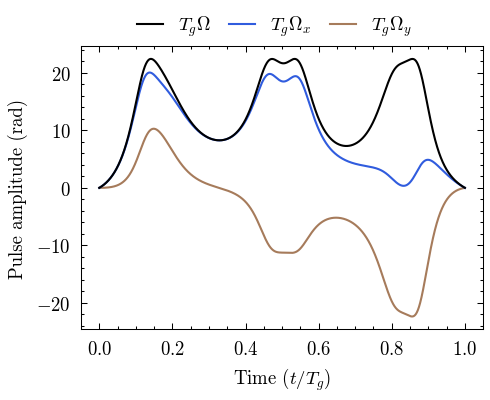

In [35]:
barqcurve_2.plot_fields('compact')


zz_loss(barqcurve_2.frenet_dict)

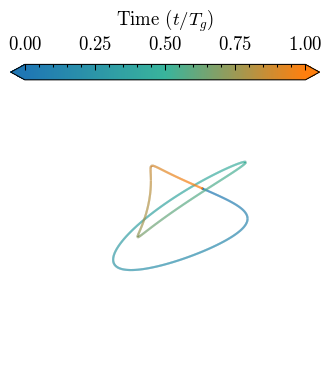

In [69]:
barqcurve_2.plot_position()
plt.gca().view_init(elev=125, roll=125)

plt.savefig("figure.svg", format="svg")

In [40]:
plt.savefig('Barq_curve_1.svg')

<Figure size 487.5x365.625 with 0 Axes>

In [157]:
from qurveros.qubit_bench import simulator
1-simulator.simulate_control_dict(barqcurve_2.get_control_dict(), qutip.sigmaz())['avg_gate_fidelity']

1.113553693699032e-13

In [268]:
barqcurve_2['-1']['loss_grad_value']

{'free_points': Array([[ 4.53343516e-06, -4.28082329e-06,  2.01731341e-06],
        [ 4.73584087e-06,  1.05956347e-06,  4.17201514e-06],
        [ 1.76062589e-05, -1.29777011e-05, -7.17591593e-06],
        [ 8.33727810e-06, -4.58374801e-06, -1.14502503e-05],
        [ 3.19792773e-06, -4.02700901e-07, -9.05563243e-06],
        [ 1.59348735e-06,  1.45702863e-06, -5.66753940e-06],
        [ 1.07513397e-06,  2.67697316e-06, -2.90027780e-06],
        [ 7.29911412e-07,  3.53397752e-06, -9.74888976e-07],
        [ 5.11308398e-07,  3.78924553e-06,  1.46575915e-07],
        [ 4.39105007e-07,  3.33428280e-06,  6.28758049e-07]],      dtype=float64),
 'pgf_params': {'barq_angle': Array(-7.2535045e-08, dtype=float64),
  'left_binormal_aux': Array(0., dtype=float64),
  'left_binormal_fix': Array(0., dtype=float64),
  'left_tangent_aux': Array(0., dtype=float64),
  'left_tangent_fix': Array(0., dtype=float64),
  'norm_value': Array(1.66429767e-05, dtype=float64),
  'right_binormal_aux': Array(1.20007

In [269]:
omega_tr = barqcurve_2.get_control_dict()['omega']
phi_tr   = barqcurve_2.get_control_dict()['phi']
delta_tr = barqcurve_2.get_control_dict()['delta']

In [270]:

data = np.column_stack((omega_X1, omega_tr, phi_tr, delta_tr))  # shape (4096, 4)

name = 'XZ_gate_gauss_GREAT_2_no_trantrix_optimiation_E.csv'
np.savetxt(name, data, delimiter=",")
np.savetxt(
    name,
    data,
    delimiter=","
)

del omega_tr, phi_tr, delta_tr

In [ ]:
tangent_1 = barqcurve_1.frenet_dict['frame'][:, 0, :]           # get tangent curve


tangent_2 = barqcurve_2.frenet_dict['frame'][:, 0, :]           # get tangent curve

In [ ]:
speed_1 = barqcurve_1.frenet_dict['speed']

speed_1

In [ ]:
def fourier_coefs(t, y, N_order):
    """ This function computes the Fourier series coefficients
     Inputs:
        t       : time vector
        y       : function we want to expand in Fourier series
        N_order : highest order we keep in the expansion
    Outputs:
        c_n     : complex fourier coeefficients     
        
    """
    period   = t[-1] - t[0]                                     # time windows in which we compute the Fourier expansion
    N_order += 1                                                # total orders, we start from 0-th order DC component 
    c_n       = np.zeros(N_order)*(1+1j)                        # initialize the array of coefficients
    c_n[0]    = y.sum()/y.size                                  # 0th order coefficient, DC component
    
    for n in range(1,N_order):
       c      = y*( np.cos(2*n*np.pi*t/period) + 1j* np.sin(2*n*np.pi*t/period) )     # integrant
       c_n[n] = 2 * np.sum(c)/c.size                                                  # numerical integration

    return c_n

def f_in_FS(t, cn):
    """ This function computes the Fourier expansion
    Inputs:
        t   : time vector
        cn  : complex Fourier coefficients 
    Outputs:
        f   : Fourier expansion  
    """
    period        = t[-1] - t[0]                                # time windows in which we compute the Fourier expansion
    c_n_real      = np.real(cn)                                 # cosine coefs
    c_n_imaginary = np.imag(cn)                                 # sine coefs
    f             = c_n_real[0] * np.ones(len(t)) + 1j*0        # DC componenet

    for n in range(1,len(cn)):
        f += c_n_real[n] * np.cos(n * 2*np.pi * t/period) + c_n_imaginary[n] * np.sin(n * 2*np.pi *t/period)  # add order by order
   
    return f

# === Central difference for derivatives ===
def central_diff(f, dt):
    df       = np.zeros_like(f)
    df[1:-1] = (f[2:] - f[:-2]) / (2 * dt)
    df[0]    = (f[1] - f[0]) / dt
    df[-1]   = (f[-1] - f[-2]) / dt
    return df

import matplotlib.pyplot as plt

In [ ]:
N_poins = np.size(tangent_1,0)

time = np.linspace(0,1,N_poins)

f_order = 5

cn_1 = np.zeros((f_order+1, 3))*(1+1j)
cn_2 = np.zeros((f_order+1, 3))*(1+1j)

for q in range(0,3):
    cn_1[:,q]  = fourier_coefs(time, tangent_1[:,q], f_order)       # compute the coefs

fs_tangent_1 = np.column_stack((f_in_FS(time, cn_1[:,0]), 
                               f_in_FS(time, cn_1[:,1]),
                               f_in_FS(time, cn_1[:,2])))

fs_tangent_1 = np.real(fs_tangent_1) /np.linalg.norm(fs_tangent_1,axis=1)[:,None] 


for q in range(0,3):
    cn_2[:,q]  = fourier_coefs(time, tangent_2[:,q], f_order)       # compute the coefs

fs_tangent_2 = np.column_stack((f_in_FS(time, cn_2[:,0]), 
                               f_in_FS(time, cn_2[:,1]),
                               f_in_FS(time, cn_2[:,2])))

fs_tangent_2 = np.real(fs_tangent_2) /np.linalg.norm(fs_tangent_2,axis=1)[:,None] 

plt.plot(time, np.linalg.norm(tangent_2, axis =1))
plt.plot(time, np.linalg.norm(fs_tangent_2, axis = 1))

plt.plot(time, tangent_1[:,0])
plt.plot(time, fs_tangent_1[:,0])

In [ ]:
kappa_barq_1 = barqcurve_1.get_control_dict()["omega"]

# kappa_barq_1 = barqcurve_1.frenet_dict["curvature"]

kappa_barq_2 = barqcurve_2.get_control_dict()["omega"]

dt      = time[1] - time[0]

""" tangent_1_dot = np.column_stack( (central_diff(tangent_1[:,0], dt),
                                  central_diff(tangent_1[:,1], dt),
                                  central_diff(tangent_1[:,2], dt))) """

tangent_1_dot = np.gradient(tangent_1, dt, edge_order=2, axis=0) 
tangent_2_dot = np.gradient(tangent_2, dt, edge_order=2, axis=0)
                                 
kappa_1       = np.linalg.norm(tangent_1_dot, axis = 1)/speed_1

""" tangent_2_dot = central_diff(tangent_2, dt) """
kappa_2       = np.linalg.norm(tangent_2_dot, axis = 1)


plt.plot(time,kappa_barq_1)
# plt.plot(time, kappa_1)
plt.plot(barqcurve_1.frenet_dict['length']/barqcurve_1.frenet_dict['length'][-1], kappa_1 * barqcurve_1.frenet_dict['length'][-1])

plt.plot 

####plt.plot(barqcurve_1.control_dict['times'], barqcurve_1.control_dict['omega'])

# plt.plot(kappa_barq_1 - kappa_1 * barqcurve_1.frenet_dict['length'][-1])

""" plt.plot(time,kappa_barq_2)
plt.plot(time, kappa_2) """



In [ ]:
dt = (time[1] - time[0])

length = jnp.cumsum(barqcurve_1.frenet_dict['speed'])/ N_poins

#plt.plot( barqcurve_1.frenet_dict['length'])
#plt.plot( barqcurve_1.frenet_dict['speed'] )
#plt.plot( length)
plt.plot(length - barqcurve_1.frenet_dict['length'])
# plt.ylim([0.99, 1.01])



In [ ]:
barqcurve_1.get_frenet_dict()

In [ ]:
from scipy.interpolate import interp1d

t_linear    = np.linspace(0,1,100)
t_nonlinear = t_linear + 0.1*np.sin(np.pi/2 * t_linear)
t_nonlinear /= t_nonlinear[-1]
print(t_nonlinear[-1])

f_linear = np.ones(100)
f_linear = np.exp(-(t_linear - 0.5)**2 / 0.05)
f_linear = np.cos(2*np.pi * t_linear)

f_nonl          = interp1d(t_linear, f_linear, kind='cubic', fill_value="extrapolate")

f_nonlinear     = f_nonl(t_nonlinear)

f_nonlinear_jax = jnp.interp(t_nonlinear, t_linear, f_linear)


plt.plot(t_linear, f_linear)
# plt.plot(t_linear, t_nonlinear)
plt.plot(t_nonlinear, f_nonlinear)
plt.plot(t_nonlinear, f_nonlinear_jax)

